# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import patsy
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [5]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [6]:
element_gameweek_df = pd.read_csv(file_name)

In [7]:
current_event = 20

In [8]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [9]:
element_gameweek_df.fillna(3, inplace=True)

In [10]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,3.0,3.0,3.0,3.0,3.0,3,3.000000,3.000000,3.000000,3.0
1,cech,1,2,14,1,6,0,1,50,0,...,3.0,3.0,3.0,3.0,3.0,3,0.681818,3.000000,3.000000,3.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,3.0,3.0,3.0,3,3.750000,0.000000,3.000000,3.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,3.0,6.0,3.0,1,4.493304,0.000000,4.901786,3.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [11]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [12]:
last_train_event = 15

In [13]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [14]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [15]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [16]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [17]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [18]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [19]:
n_features = X.shape[1]

## Selecting features

In [153]:
estimator = RandomForestRegressor(n_estimators=140,
                                  max_features=0.8,
                                  min_samples_leaf=0.015,
                                  random_state=0)
selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
F

Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
F

Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                      max_depth=None, max_features=0.8,
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=0.015,
                                      min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=140, n_jobs=None,
                                      oob_score=False, random_state=0,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [155]:
features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
selected_features = pd.Series(features)[selector.support_]
list(selected_features)

['value',
 'is_late',
 'rolling_avg_total_points_element',
 'rolling_var_total_points_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_total_points_element_type',
 'rolling_avg_total_points_own_team',
 'rolling_avg_total_points_opposition_team',
 'rolling_avg_total_points_against_opposition_team',
 'rolling_avg_total_points_against_opposition_team_element_type',
 'expected_avg_total_points_against_opposition_

In [156]:
stark_X_sel = X[:,selector.support_]
stark_X_train_sel = X_train[:,selector.support_]
stark_X_test_sel = X_test[:,selector.support_]

In [28]:
lush_X_sel = X
lush_X_train_sel = X_train
lush_X_test_sel = X_test

## Tuning model

### GP tuner

#### Random forest (lush)

In [57]:
lush_space = [
    Integer(40, 150, name='n_estimators'),
    Real(0.8, 0.9, 'uniform', name='max_features'),
    Real(0.01, 0.03, 'uniform', name='min_samples_leaf'),
]

In [58]:
lush_gp_model = RandomForestRegressor()

@use_named_args(lush_space)
def lush_objective(**params):
    lush_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lush_gp_model,
            lush_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [65]:
lush_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    lush_res_gp = gp_minimize(lush_objective, lush_space, n_calls=20, verbose=2)
    lush_res_gp_arr.append(lush_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.4283
Function value obtained: 9.4905
Current minimum: 9.4905
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6706
Function value obtained: 9.4277
Current minimum: 9.4277
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.3672
Function value obtained: 9.4554
Current minimum: 9.4277
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.5840
Function value obtained: 9.4289
Current minimum: 9.4277
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.9925
Function value obtained: 9.4233
Current minimum: 9.4233
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 6.1899
Function value obtained: 9.4343
Current minimum: 9.4104
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 4.4316
Function value obtained: 9.4609
Current minimum: 9.4104
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 4.6820
Function value obtained: 9.4510
Current minimum: 9.4104
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.7342
Function value obtained: 9.4591
Current minimum: 9.4104
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 3.6296
Function value obtained: 9.4708
Current minimum: 9.4104
minimisation iteration 3
Iter

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.0459
Function value obtained: 9.4621
Current minimum: 9.3785
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 5.1930
Function value obtained: 9.4010
Current minimum: 9.3785
minimisation iteration 4
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.0765
Function value obtained: 9.4512
Current minimum: 9.4512
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.5916
Function value obtained: 9.4626
Current minimum: 9.4512
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.7520
Function value obtained: 9.3975
Current minimum: 9.3975
Iteration No: 4 started. Evaluating function a

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 5.6678
Function value obtained: 9.4475
Current minimum: 9.3818
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.6783
Function value obtained: 9.5240
Current minimum: 9.3818
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 5.1858
Function value obtained: 9.4428
Current minimum: 9.3818
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 4.8084
Function value obtained: 9.3800
Current minimum: 9.3800
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 4.9229
Function value obtained: 9.4296
Current minimum: 9.3800
Iteration No: 17 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.1840
Function value obtained: 9.4388
Current minimum: 9.3916
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 5.4632
Function value obtained: 9.4383
Current minimum: 9.3916


In [70]:
for i in lush_res_gp_arr:
    print(i.fun)
print('\n')
for i in lush_res_gp_arr:
    print(i.x)

9.386020386046724
9.410404672676089
9.378528617903264
9.379951206732684
9.391575445071966


[93, 0.891187617662068, 0.01546813641688589]
[97, 0.8062282628687947, 0.014917252145619387]
[101, 0.8676353436636609, 0.017440291603106856]
[150, 0.8011838584928157, 0.01954816763268799]
[150, 0.8969685724647998, 0.01699760144629301]


#### Random forest (stark)

In [189]:
stark_space = [
    Integer(100, 150, name='n_estimators'),
    Real(0.55, 0.8, 'uniform', name='max_features'),
    Real(0.01, 0.02, 'uniform', name='min_samples_leaf')
]

In [190]:
stark_gp_model = RandomForestRegressor()

@use_named_args(stark_space)
def stark_objective(**params):
    stark_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            stark_gp_model,
            stark_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [191]:
stark_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    stark_res_gp = gp_minimize(stark_objective, stark_space, n_calls=30, verbose=2)
    stark_res_gp_arr.append(stark_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.1109
Function value obtained: 9.4033
Current minimum: 9.4033
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6337
Function value obtained: 9.4136
Current minimum: 9.4033
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2670
Function value obtained: 9.4178
Current minimum: 9.4033
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.3836
Function value obtained: 9.4131
Current minimum: 9.4033
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.8595
Function value obtained: 9.3892
Current minimum: 9.3892
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.7662
Function value obtained: 9.4099
Current minimum: 9.3892
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.2912
Function value obtained: 9.4509
Current minimum: 9.3892
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.9438
Function value obtained: 9.4050
Current minimum: 9.3892
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.4309
Function value obtained: 9.4236
Current minimum: 9.3892
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.4051
Function value obtained: 9.4455
Current minimum: 9.3892
Iteration No: 20 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 2.1738
Function value obtained: 9.3926
Current minimum: 9.3892
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.8559
Function value obtained: 9.4018
Current minimum: 9.3892
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.0256
Function value obtained: 9.4306
Current minimum: 9.3892
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.0296
Function value obtained: 9.3982
Current minimum: 9.3892
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.7669
Function value obtained: 9.4681
Current minimum: 9.3892
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.9688
Function value obtained: 9.4064
Current minimum: 9.3892
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.2697
Function value obtained: 9.3621
Current minimum: 9.3621
Iteration No: 27 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.2839
Function value obtained: 9.4409
Current minimum: 9.3621
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.1372
Function value obtained: 9.3727
Current minimum: 9.3621
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.3679
Function value obtained: 9.4391
Current minimum: 9.3621
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.3935
Function value obtained: 9.3590
Current minimum: 9.3590
minimisation iteration 2
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5668
Function value obtained: 9.4030
Current minimum: 9.4030
Iteration No: 2 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.5866
Function value obtained: 9.4133
Current minimum: 9.3856
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.5477
Function value obtained: 9.4074
Current minimum: 9.3856
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.7063
Function value obtained: 9.4052
Current minimum: 9.3856
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.8148
Function value obtained: 9.4160
Current minimum: 9.3856
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.4906
Function value obtained: 9.4259
Current minimum: 9.3856
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.2112
Function value obtained: 9.3706
Current minimum: 9.3706
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.1188
Function value obtained: 9.4288
Current minimum: 9.3706
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.5069
Function value obtained: 9.4716
Current minimum: 9.3706
minimisation iteration 3
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3631
Function value obtained: 9.4030
Current minimum: 9.4030
Iteration No: 2 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.7906
Function value obtained: 9.4379
Current minimum: 9.3918
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.4518
Function value obtained: 9.3761
Current minimum: 9.3761
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.8702
Function value obtained: 9.4334
Current minimum: 9.3761
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.9013
Function value obtained: 9.4080
Current minimum: 9.3761
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.4695
Function value obtained: 9.4652
Current minimum: 9.3761
Iteration No: 18 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.8137
Function value obtained: 9.3900
Current minimum: 9.3761
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.5979
Function value obtained: 9.4393
Current minimum: 9.3761
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.5787
Function value obtained: 9.4551
Current minimum: 9.3761
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.7918
Function value obtained: 9.4052
Current minimum: 9.3761
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.0317
Function value obtained: 9.4542
Current minimum: 9.3761
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.6421
Function value obtained: 9.4270
Current minimum: 9.3761
minimisation iteration 4
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2202
Function value obtained: 9.4309
Current minimum: 9.4309
Iteration No: 2 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.4343
Function value obtained: 9.4111
Current minimum: 9.3784
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.8255
Function value obtained: 9.3995
Current minimum: 9.3784
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.0754
Function value obtained: 9.4315
Current minimum: 9.3784
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.1700
Function value obtained: 9.4229
Current minimum: 9.3784
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.5670
Function value obtained: 9.3854
Current minimum: 9.3784
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.4990
Function value obtained: 9.3686
Current minimum: 9.3686
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.3079
Function value obtained: 9.4197
Current minimum: 9.3686
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.5114
Function value obtained: 9.4370
Current minimum: 9.3686
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.9820
Function value obtained: 9.3983
Current minimum: 9.3686
Iteration No: 24 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 3.0199
Function value obtained: 9.4325
Current minimum: 9.3816
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.5675
Function value obtained: 9.3861
Current minimum: 9.3816
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.5577
Function value obtained: 9.3963
Current minimum: 9.3816
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.5547
Function value obtained: 9.4236
Current minimum: 9.3816
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.9273
Function value obtained: 9.4341
Current minimum: 9.3816
Iteration No: 23 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.7173
Function value obtained: 9.4511
Current minimum: 9.3816
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.2441
Function value obtained: 9.3703
Current minimum: 9.3703
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.9116
Function value obtained: 9.3960
Current minimum: 9.3703
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.1909
Function value obtained: 9.3735
Current minimum: 9.3703
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.3968
Function value obtained: 9.4317
Current minimum: 9.3703
Iteration No: 30 started. Sea

In [192]:
for i in stark_res_gp_arr:
    print(i.fun)
print('\n')
for i in stark_res_gp_arr:
    print(i.x)

9.358976543831972
9.37064729567933
9.376069254836631
9.368571589720743
9.37034275240458


[150, 0.75, 0.01]
[100, 0.7457610056321325, 0.01062464462661116]
[147, 0.7494547971911353, 0.019936009470566472]
[101, 0.5521895633785489, 0.019606107689957374]
[100, 0.75, 0.01]


### Grid search

#### Random forest (lush)

In [79]:
min_samples_leaf_lush = [0.01475, 0.015, 0.01525]
max_features_lush = [0.835, 0.84, 0.845]

parameters_lush = {
    'min_samples_leaf': min_samples_leaf_lush,
    'max_features': max_features_lush
}

In [80]:
gs_model_lush = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=0),
    parameters_lush,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_lush.fit(lush_X_sel, y.ravel())

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_features=0.835, min_samples_leaf=0.01475 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... max_features=0.835, min_samples_leaf=0.01475, total=   3.1s
[CV] max_features=0.835, min_samples_leaf=0.015 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ....... max_features=0.835, min_samples_leaf=0.015, total=   2.9s
[CV] max_features=0.835, min_samples_leaf=0.01525 ....................
[CV] ..... max_features=0.835, min_samples_leaf=0.01525, total=   2.9s
[CV] max_features=0.84, min_samples_leaf=0.01475 .....................
[CV] ...... max_features=0.84, min_samples_leaf=0.01475, total=   2.9s
[CV] max_features=0.84, min_samples_leaf=0.015 .......................
[CV] ........ max_features=0.84, min_samples_leaf=0.015, total=   2.9s
[CV] max_features=0.84, min_samples_leaf=0.01525 .....................
[CV] ...... max_features=0.84, min_samples_leaf=0.01525, total=   2.8s
[CV] max_features=0.845, min_samples_leaf=0.01475 ....................
[CV] ..... max_features=0.845, min_samples_leaf=0.01475, total=   3.0s
[CV] max_features=0.845, min_samples_leaf=0.015 ......................
[CV] ....... max_features=0.845, min_samples_leaf=0.015, total=   3.0s
[CV] max_features=0.845, min_samples_leaf=0.01525 ....................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.3s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=1,
             p

In [81]:
gs_model_df_lush = pd.DataFrame(gs_model_lush.cv_results_)[[
    'param_min_samples_leaf', 'param_max_features',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df_lush

,param_min_samples_leaf,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.01475,0.835,-2.168589,-9.392350
1,0.015,0.835,-2.167898,-9.399745
2,0.01525,0.835,-2.166193,-9.398748
3,0.01475,0.84,-2.167800,-9.382302
4,0.015,0.84,-2.166983,-9.350623
5,0.01525,0.84,-2.169434,-9.374593
6,0.01475,0.845,-2.172239,-9.370144
7,0.015,0.845,-2.174884,-9.383600
8,0.01525,0.845,-2.167449,-9.383434


In [82]:
gs_model_df_lush[
    gs_model_df_lush['split0_test_neg_mean_squared_error'] == \
    gs_model_df_lush['split0_test_neg_mean_squared_error'].max()]

,param_min_samples_leaf,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
4,0.015,0.84,-2.166983,-9.350623


#### Random forest (stark)

In [206]:
min_samples_leaf_stark = [0.0125, 0.013, 0.0135]
max_features_stark = [0.7, 0.71, 0.72, 0.73, 0.74]

parameters_stark = {
    'min_samples_leaf': min_samples_leaf_stark,
    'max_features': max_features_stark,
}

In [207]:
gs_model_stark = GridSearchCV(
    RandomForestRegressor(n_estimators=120, random_state=0),
    parameters_stark,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_stark.fit(stark_X_sel, y.ravel())

Fitting 1 folds for each of 15 candidates, totalling 15 fits
[CV] max_features=0.7, min_samples_leaf=0.0125 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_features=0.7, min_samples_leaf=0.0125, total=   1.6s
[CV] max_features=0.7, min_samples_leaf=0.013 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ......... max_features=0.7, min_samples_leaf=0.013, total=   1.6s
[CV] max_features=0.7, min_samples_leaf=0.0135 .......................
[CV] ........ max_features=0.7, min_samples_leaf=0.0135, total=   1.6s
[CV] max_features=0.71, min_samples_leaf=0.0125 ......................
[CV] ....... max_features=0.71, min_samples_leaf=0.0125, total=   1.7s
[CV] max_features=0.71, min_samples_leaf=0.013 .......................
[CV] ........ max_features=0.71, min_samples_leaf=0.013, total=   1.6s
[CV] max_features=0.71, min_samples_leaf=0.0135 ......................
[CV] ....... max_features=0.71, min_samples_leaf=0.0135, total=   1.6s
[CV] max_features=0.72, min_samples_leaf=0.0125 ......................
[CV] ....... max_features=0.72, min_samples_leaf=0.0125, total=   1.7s
[CV] max_features=0.72, min_samples_leaf=0.013 .......................
[CV] ........ max_features=0.72, min_samples_leaf=0.013, total=   1.7s
[CV] max_features=0.72, min_samples_leaf=0.0135 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   24.9s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=120, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=1,
             p

In [208]:
gs_model_df_stark = pd.DataFrame(gs_model_stark.cv_results_)[[
    'param_min_samples_leaf',
    'param_max_features',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df_stark

,param_min_samples_leaf,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.0125,0.7,-2.163029,-9.381536
1,0.013,0.7,-2.162579,-9.369272
2,0.0135,0.7,-2.166982,-9.392482
3,0.0125,0.71,-2.163029,-9.381536
4,0.013,0.71,-2.162579,-9.369272
5,0.0135,0.71,-2.166982,-9.392482
6,0.0125,0.72,-2.158541,-9.373429
7,0.013,0.72,-2.159798,-9.366370
8,0.0135,0.72,-2.161382,-9.356752
9,0.0125,0.73,-2.158541,-9.373429


In [209]:
gs_model_df_stark[
    gs_model_df_stark['split0_test_neg_mean_squared_error'] == \
    gs_model_df_stark['split0_test_neg_mean_squared_error'].max()]

,param_min_samples_leaf,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
8,0.0135,0.72,-2.161382,-9.356752
11,0.0135,0.73,-2.161382,-9.356752
14,0.0135,0.74,-2.161382,-9.356752


# Evaluating model

## Random forest (lush)

In [83]:
lush_model = RandomForestRegressor(n_estimators=100,
                                   min_samples_leaf=0.015,
                                   max_features=0.84,
                                   random_state=0)
lush_model.fit(lush_X_train_sel, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.84, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.015, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [84]:
# get predictions for test set
lush_y_pred = lush_model.predict(lush_X_test_sel).flatten()

# calculate cross entropy loss for test set
lush_test_loss = (
    mean_absolute_error(y_test, lush_y_pred),
    mean_squared_error(y_test, lush_y_pred),
    r2_score(y_test, lush_y_pred)
)
lush_test_loss

(2.1669828106595967, 9.35062266952851, 0.10149100002908784)

In [85]:
pd.Series(lush_y_pred).describe()

count    948.000000
mean       2.680871
std        0.928081
min        1.123442
25%        2.002107
50%        2.470561
75%        3.280000
max        5.754430
dtype: float64

In [88]:
# refit model on all data
lush_model_full = RandomForestRegressor(n_estimators=100,
                                        min_samples_leaf=0.015,
                                        max_features=0.84,
                                        random_state=0)
lush_model_full.fit(lush_X_sel, y.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.84, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.015, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [89]:
# get predictions for whole set
lush_y_pred_full = lush_model_full.predict(lush_X_sel).flatten()

# calculate cross entropy loss for test set
lush_test_loss_full = (
    mean_absolute_error(y, lush_y_pred_full),
    mean_squared_error(y, lush_y_pred_full),
    r2_score(y, lush_y_pred_full)
)
lush_test_loss_full

(2.017174701658425, 7.71605531086578, 0.1936030471608805)

In [90]:
pd.Series(lush_y_pred_full).describe()

count    3644.000000
mean        2.866212
std         0.962938
min         0.944369
25%         2.156237
50%         2.783663
75%         3.486151
max         6.355975
dtype: float64

In [91]:
abs(pd.Series(y.ravel()) - pd.Series(lush_y_pred_full)).describe()

count    3644.000000
mean        2.017175
std         1.909990
min         0.000082
25%         0.738745
50%         1.580626
75%         2.595265
max        14.953776
dtype: float64

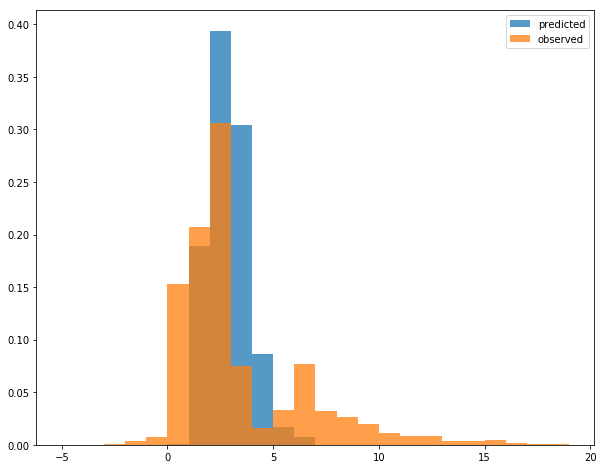

In [92]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

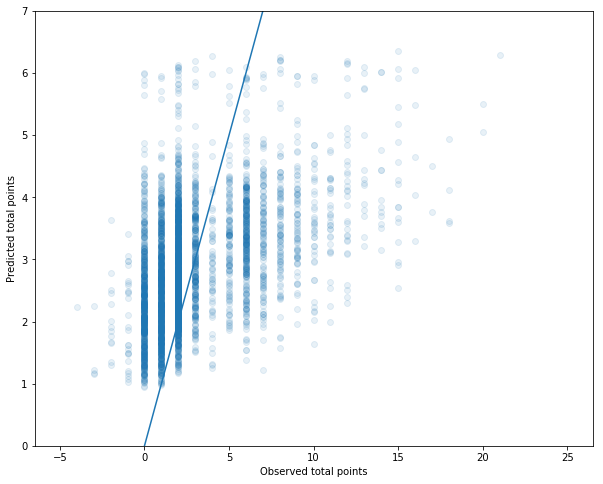

In [93]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lush_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Random forest (stark)

In [210]:
stark_model = RandomForestRegressor(n_estimators=120,
                                    min_samples_leaf=0.0135,
                                    max_features=0.73,
                                    random_state=0)
stark_model.fit(stark_X_train_sel, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.73, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.0135, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=120,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [211]:
# get predictions for test set
stark_y_pred = stark_model.predict(stark_X_test_sel).flatten()

# calculate cross entropy loss for test set
stark_test_loss = (
    mean_absolute_error(y_test, stark_y_pred),
    mean_squared_error(y_test, stark_y_pred),
    r2_score(y_test, stark_y_pred)
)
stark_test_loss

(2.1613823632061178, 9.356751803771857, 0.1009020464936593)

In [212]:
pd.Series(stark_y_pred).describe()

count    948.000000
mean       2.664531
std        0.927519
min        1.090403
25%        1.989409
50%        2.444280
75%        3.245256
max        5.787189
dtype: float64

In [221]:
# refit model on all data
stark_model_full = RandomForestRegressor(n_estimators=120,
                                         min_samples_leaf=0.0135,
                                         max_features=0.73,
                                         random_state=0)
stark_model_full.fit(stark_X_sel, y.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.73, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.0135, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=120,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [222]:
# get predictions for whole set
stark_y_pred_full = stark_model_full.predict(stark_X_sel).flatten()

# calculate cross entropy loss for test set
stark_test_loss_full = (
    mean_absolute_error(y, stark_y_pred_full),
    mean_squared_error(y, stark_y_pred_full),
    r2_score(y, stark_y_pred_full)
)
stark_test_loss_full

(2.0108654262277286, 7.670925098273149, 0.19831955895991216)

In [223]:
pd.Series(stark_y_pred_full).describe()

count    3644.000000
mean        2.868794
std         0.972283
min         0.945918
25%         2.151461
50%         2.795469
75%         3.486643
max         6.388196
dtype: float64

In [224]:
abs(pd.Series(y.ravel()) - pd.Series(stark_y_pred_full)).describe()

count    3644.000000
mean        2.010865
std         1.904820
min         0.001219
25%         0.758762
50%         1.564144
75%         2.577471
max        15.123039
dtype: float64

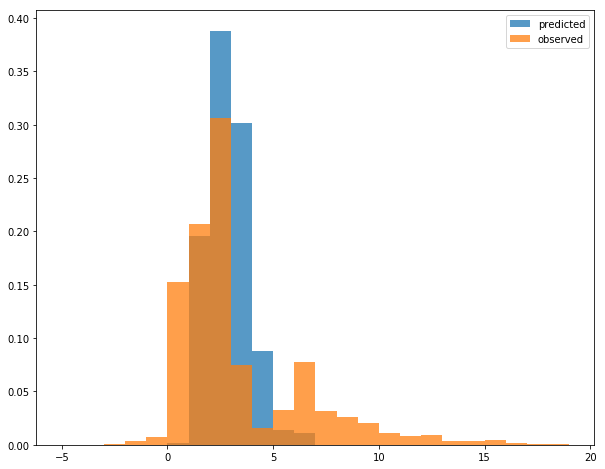

In [225]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

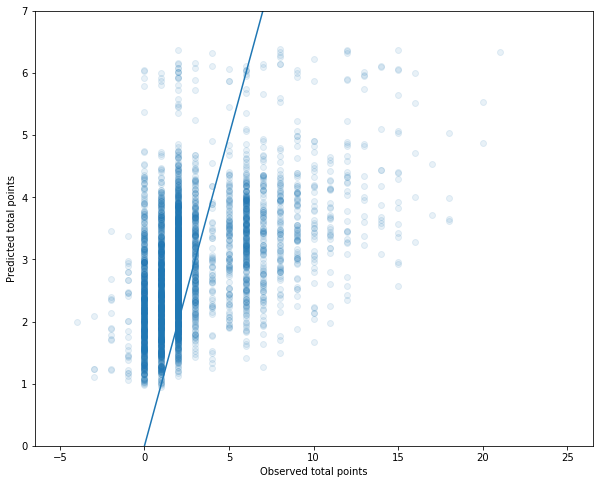

In [226]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(stark_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Summary

In [227]:
pd.DataFrame([
    ('Random forest (lush)', lush_test_loss[0], lush_test_loss[1], lush_test_loss[2]),
    ('Random forest (stark)', stark_test_loss[0], stark_test_loss[1], stark_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Random forest (lush),2.166983,9.350623,0.101491
1,Random forest (stark),2.161382,9.356752,0.100902


In [228]:
pd.DataFrame([
    ('Random forest (lush)', lush_test_loss_full[0], lush_test_loss_full[1], lush_test_loss_full[2]),
    ('Random forest (stark)', stark_test_loss_full[0], stark_test_loss_full[1], stark_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Random forest (lush),2.017175,7.716055,0.193603
1,Random forest (stark),2.010865,7.670925,0.198320
